In [1]:
import pandas as pd
import re
import json
import matplotlib.pyplot as plt
import glob, os, csv

from langdetect import detect

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import CoherenceModel

from pprint import pprint

import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'http', 'javascript', 'onion', 'site', 'com'])

from bs4 import BeautifulSoup

# import pyLDAvis
# import pyLDAvis.gensim

import ast
from collections import Counter
from operator import add
from wordcloud import WordCloud

# import stanza
# # stanza.download('en')
# nlp = stanza.Pipeline('en', processors='tokenize,mwt,pos,lemma')

In [2]:
# Convert html file to texts
def body2text(file):
    html = open(file, "rb")
    soup = BeautifulSoup(html, "html.parser")
    result = []
    # kill all script and style elements
    for script in soup(["script", "style"]):
        script.extract()

    text = soup.get_text()
    # break into lines and remove leading and trailing space on each
    lines = (line.strip() for line in text.splitlines())
    for line in lines:
        if line:
            result.append(line)
    html.close()

    return result

In [3]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text))

def preprocess(sentences):
    result = []
    
    for sent in sentences:
        lemmas = []
        # tokenize
        tokens = gensim.utils.simple_preprocess(sent)
        for token in tokens:
            lemma = lemmatize_stemming(token)
            # remove stopwords
            if lemma not in stop_words:
                lemmas.append(lemma)
        # POS tagging
        nltk_tagged = nltk.pos_tag(lemmas)
        for word, tag in nltk_tagged:
            result.append(word)
            # only keep nouns
#             if tag.startswith('N'):
#                 result.append(word)
    return result

In [4]:
def language_detect(ls):
    text = ' '.join(ls)
    result = detect(text)
    return result

In [5]:
# df_train = pd.read_csv('../data/trainset.csv')
# df_train.drop(columns='Unnamed: 0', inplace=True)
df_test = pd.read_csv('../data/testset.csv')
df_test.drop(columns='Unnamed: 0', inplace=True)
# convert the string representation of a list into a list
# df_train['body_text'] = df_train['body_text'].apply(ast.literal_eval)
df_test['body_text'] = df_test['body_text'].apply(ast.literal_eval)
df_test['title'] = df_test['title'].apply(ast.literal_eval)
df_test['body_token'] = df_test['body_token'].apply(ast.literal_eval)
df_test['title_token'] = df_test['title_token'].apply(ast.literal_eval)

In [6]:
# Universe Sample
df_test

,cluster_name,domain,url,title,body_text,body_token,title_token,language
0,! CLONED CARDS !,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,[! CLONED CARDS !],"[! CLONED CARDS !, Home, Price, Shipping, Ques...","[clone, card, home, price, ship, question, con...","[clone, card]",en
1,$$ The Green Machine $$ - Error,['he22pncoselnm54h'],['he22pncoselnm54h.onion'],[$$ The Green Machine $$ - Error ],[$$ The Green Machine $$ - Error You have been...,"[machin, error, log, session, ha, expir, pleas]","[machin, error]",en
2,$$$ Credit Cards | PayPal | Wester Union | Mon...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,"[credit, card, wester, union, moneygram, accou...","[credit, card, wester, union, moneygram, accou...",en
3,&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&#...,['darkfailllnkf4vf'],['darkfailllnkf4vf.onion'],[&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&...,"[d﻿ark.fai﻿l: Which darknet sites are online?,...","[ark, darknet, site, onlin, darknet, site, onl...","[darknet, site, onlin]",en
4,&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dres...,['rvy6qmlqfstv6rlz'],['rvy6qmlqfstv6rlz.onion'],[&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dre...,"[<<</>> Chaos Computer Club Dresden | c3d2, <<...","[chao, comput, club, dresden, chao, comput, cl...","[lt, lt, lt, gt, gt, chao, comput, club, dresden]",en
...,...,...,...,...,...,...,...,...
1330,淡路島,['a5h4uuqoovwvcbiecjkjlu7ew7z4lszfv67dodqol2iv...,['a5h4uuqoovwvcbiecjkjlu7ew7z4lszfv67dodqol2iv...,[淡路島],"[淡路島, 淡路島 - コシニテ人びとへの手紙 -, 玉ねぎを育もう, Update, 20...","[淡路島, 淡路島, コシニテ人びとへの手紙, 玉ねぎを育もう, updat, scale,...",[淡路島],ja
1331,约伊兹的萌狼乡手札,"['horoiomuy6xignjv', 'qty3gmiq3zhs7whorla4ynvm...","['horoiomuy6xignjv.onion', 'qty3gmiq3zhs7whorl...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]","[约伊兹的萌狼乡手札, vertical_align_top重新开始？🙃, menu, 约伊...","[约伊兹的萌狼乡手札, menu, 约伊兹的萌狼乡手札, more_vert, ホロ, 且被...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]",en
1332,茶马古道,['7zj4oshsyhokgus6fyk7pmdiubu4mkjpjjprjkvopnhn...,['7zj4oshsyhokgus6fyk7pmdiubu4mkjpjjprjkvopnhn...,[茶马古道],"[茶马古道, 茶马护盾已开启欢迎来到茶马古道，页面跳转中...]","[茶马古道, 茶马护盾已开启欢迎来到茶马古道, 页面跳转中]",[茶马古道],ko
1333,藤原太一 犯罪者 窃盗 脅迫 たかり 亘心綜合音楽事務所 太眉,['6tert2z5hydswwvt'],['6tert2z5hydswwvt.onion'],[藤原太一 犯罪者 窃盗 脅迫 たかり 亘心綜合音楽事務所 太眉],[藤原太一 犯罪者 窃盗 脅迫 たかり 亘心綜合音楽事務所 太眉],"[犯罪者, 窃盗, 脅迫, たかり, 亘心綜合音楽事務所, 太眉]","[犯罪者, 窃盗, 脅迫, たかり, 亘心綜合音楽事務所, 太眉]",ko


In [7]:
# Universe Sample - English Websites
df_test_eng = df_test[df_test['language'] == 'en']
df_test_eng

,cluster_name,domain,url,title,body_text,body_token,title_token,language
0,! CLONED CARDS !,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,[! CLONED CARDS !],"[! CLONED CARDS !, Home, Price, Shipping, Ques...","[clone, card, home, price, ship, question, con...","[clone, card]",en
1,$$ The Green Machine $$ - Error,['he22pncoselnm54h'],['he22pncoselnm54h.onion'],[$$ The Green Machine $$ - Error ],[$$ The Green Machine $$ - Error You have been...,"[machin, error, log, session, ha, expir, pleas]","[machin, error]",en
2,$$$ Credit Cards | PayPal | Wester Union | Mon...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,"[credit, card, wester, union, moneygram, accou...","[credit, card, wester, union, moneygram, accou...",en
3,&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&#...,['darkfailllnkf4vf'],['darkfailllnkf4vf.onion'],[&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&...,"[d﻿ark.fai﻿l: Which darknet sites are online?,...","[ark, darknet, site, onlin, darknet, site, onl...","[darknet, site, onlin]",en
4,&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dres...,['rvy6qmlqfstv6rlz'],['rvy6qmlqfstv6rlz.onion'],[&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dre...,"[<<</>> Chaos Computer Club Dresden | c3d2, <<...","[chao, comput, club, dresden, chao, comput, cl...","[lt, lt, lt, gt, gt, chao, comput, club, dresden]",en
...,...,...,...,...,...,...,...,...
1304,| TheYOSH.nl,['ctzzqqimlfamyhrc'],['ctzzqqimlfamyhrc.onion'],[| TheYOSH.nl],"[| TheYOSH.nl, Skip to main content, User acco...","[theyosh, nl, skip, content, user, account, me...","[theyosh, nl]",en
1321,✉ Guerrilla Mail on Tor,['grrmailb3fxpjbwm'],['grrmailb3fxpjbwm.onion'],[✉ Guerrilla Mail on Tor],"[✉ Guerrilla Mail on Tor, TorGuerrillaMail - D...","[guerrilla, mail, tor, dispos, mail, address, ...","[guerrilla, mail, tor]",en
1322,✔ Legit Carding Services ♛ Money Transfer Worl...,['greenegbqkyk3ois'],['greenegbqkyk3ois.onion'],[✔ Legit Carding Services ♛ Money Transfer Wor...,[✔ Legit Carding Services ♛ Money Transfer Wor...,"[card, servic, money, transfer, worldwid, webs...","[card, servic, money, transfer, worldwid, webs...",en
1331,约伊兹的萌狼乡手札,"['horoiomuy6xignjv', 'qty3gmiq3zhs7whorla4ynvm...","['horoiomuy6xignjv.onion', 'qty3gmiq3zhs7whorl...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]","[约伊兹的萌狼乡手札, vertical_align_top重新开始？🙃, menu, 约伊...","[约伊兹的萌狼乡手札, menu, 约伊兹的萌狼乡手札, more_vert, ホロ, 且被...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]",en


In [8]:
# Bag of Words
docs = df_test_eng['title_token']
dictionary = gensim.corpora.Dictionary(docs)
# dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in docs]

In [9]:
# # TF-IDF
# tfidf = models.TfidfModel(bow_corpus)
# corpus_tfidf = tfidf[bow_corpus]

In [10]:
# Count words in the universe
total_count = Counter()
for doc in docs:
    doc_count = Counter(doc)
    total_count += doc_count

# Print the 100 most frequent words
total_count.most_common(100)

[('card', 4516),
 ('transfer', 2115),
 ('bitcoin', 1997),
 ('credit', 1693),
 ('onion', 1656),
 ('account', 1647),
 ('union', 1508),
 ('day', 1503),
 ('gmt', 1428),
 ('clone', 1253),
 ('market', 1154),
 ('money', 1062),
 ('shop', 932),
 ('onlin', 914),
 ('paypal', 797),
 ('dump', 771),
 ('offlin', 692),
 ('store', 631),
 ('hack', 595),
 ('moneygram', 510),
 ('servic', 454),
 ('trust', 434),
 ('btc', 399),
 ('tor', 378),
 ('visa', 363),
 ('bank', 357),
 ('transer', 341),
 ('life', 324),
 ('vendor', 307),
 ('moneywav', 307),
 ('profit', 303),
 ('doubl', 298),
 ('reliabl', 286),
 ('scam', 283),
 ('site', 277),
 ('marketplac', 270),
 ('directori', 270),
 ('fight', 261),
 ('origin', 257),
 ('appl', 255),
 ('coredir', 255),
 ('web', 249),
 ('cc', 235),
 ('gift', 226),
 ('link', 220),
 ('easi', 219),
 ('lordpay', 208),
 ('video', 203),
 ('com', 201),
 ('drug', 195),
 ('list', 194),
 ('gener', 192),
 ('everyth', 191),
 ('giftcard', 191),
 ('gc', 191),
 ('qf', 184),
 ('forum', 167),
 ('hacker',

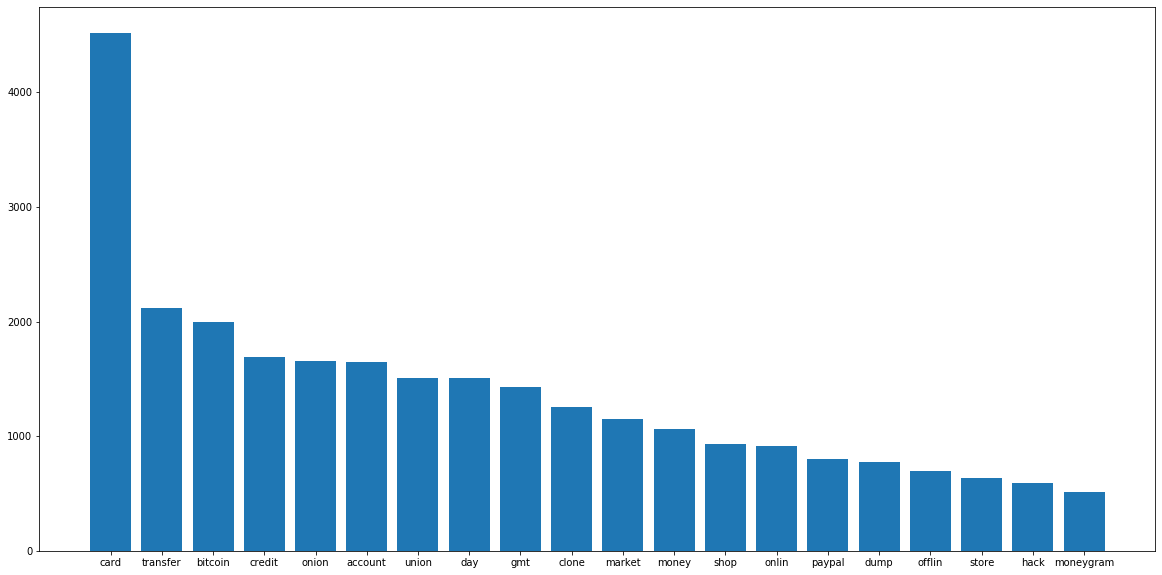

In [11]:
count_text = total_count.most_common(20)
word_labels = []
counts = []
for record in count_text:
    word_labels.append(record[0])
    counts.append(record[1])

# Show the 20 most frequent words
plt.figure(figsize=(20,10))
plt.bar(word_labels, counts)
plt.show()

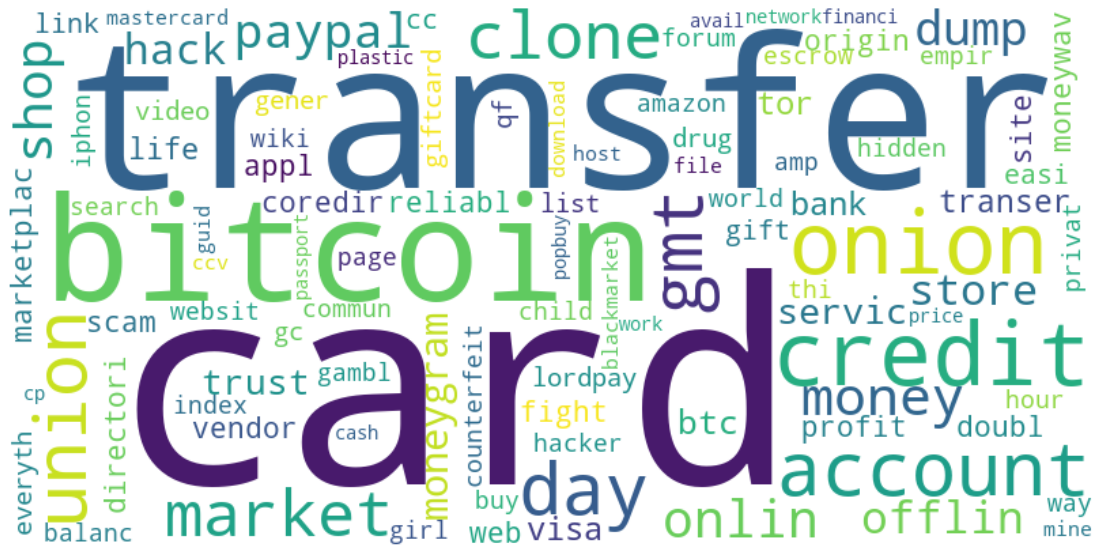

In [12]:
# Word Cloud of top 100 words
count_text = " ".join([(k + " ")*v for k,v in total_count.most_common(100)])
# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color="white", collocations = False,).generate(count_text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [13]:
# Keywords dictionary for classification
keywords_dict = {'marketplace': ['market', 'marketplace', 'shop', 'store', 'drug', 'escrow', 'wallet'], 
                'forum': ['forum'], 
                'hacking': ['hack', 'hacker'], 
                'money/credit-card/money-transfer': ['card', 'transfer', 'credit', 'union', 'money', 'paypal', 
                                                    'moneygram', 'moneywave', 'cc', 'lordpay', 'mastercard', 'ccv', 
                                                    'visa', 'cash'], 
                'ID': ['passport'], 
                'porn': ['fuck', 'child', 'teen', 'girl', 'rape'], 
                'wiki': ['wiki'], 
                'services': ['mail', 'pastebin'], 
                'personal': ['blog']}

keywords_dict_preprocessed = dict((k, preprocess(v)) for k,v in keywords_dict.items())
keywords_dict_preprocessed

{'marketplace': ['market',
  'marketplac',
  'shop',
  'store',
  'drug',
  'escrow',
  'wallet'],
 'forum': ['forum'],
 'hacking': ['hack', 'hacker'],
 'money/credit-card/money-transfer': ['card',
  'transfer',
  'credit',
  'union',
  'money',
  'paypal',
  'moneygram',
  'moneywav',
  'cc',
  'lordpay',
  'mastercard',
  'ccv',
  'visa',
  'cash'],
 'ID': ['passport'],
 'porn': ['fuck', 'child', 'teen', 'girl', 'rape'],
 'wiki': ['wiki'],
 'services': ['mail', 'pastebin'],
 'personal': ['blog']}

In [14]:
# Join all title tokens into one sentence
df_test_eng_copy = df_test_eng.copy()
df_test_eng_copy['title_token'] = df_test_eng_copy['title_token'].str.join(' ')
# df_test_eng_copy

In [15]:
# Search with the dictionary of site class words
# Keep the extracted rows
df_classified = pd.DataFrame()
for site_class in keywords_dict_preprocessed.keys():
    counter = 0
    search_keywords = '|'.join(keywords_dict_preprocessed[site_class])
    filter_index = df_test_eng_copy['title_token'].str.contains(search_keywords, case=False, na=False)
    filter_class = df_test_eng_copy[filter_index]
    if filter_index.any:
        counter += filter_class.shape[0]
        filter_class['category'] = site_class
        df_classified = df_classified.append(filter_class)
#     print(site_class, ': ', counter)

/home/mwsb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [16]:
df_classified_joined = df_classified.groupby('cluster_name').agg({'domain':'first', 'url':'first', 
                                                                  'title':'first', 'body_text':'first', 
                                                                  'body_token':'first', 'title_token': 'first',
                                                                  'language':'first', 'category': list})

# df_classified_joined['class'] = df_classified_joined['class'].str.split(',')
# set 'marketplace' as first dominant class
df_classified_joined['category'] = df_classified_joined['category'].apply(lambda x: ['marketplace'] 
                                                                    if 'marketplace' in x else x)
# set 'wiki' as second dominant class
df_classified_joined['category'] = df_classified_joined['category'].apply(lambda x: 
                                                                    ['wiki'] if 'wiki' in x else x)
# set 'money/credit-card/money-transfer' as third dominant class
df_classified_joined['category'] = df_classified_joined['category'].apply(lambda x: 
                                                                    ['money/credit-card/money-transfer'] 
                                                                    if 'money/credit-card/money-transfer' 
                                                                    in x else x)
# set 'porn' as fourth dominant class
df_classified_joined['category'] = df_classified_joined['category'].apply(lambda x: 
                                                                    ['porn'] if 'porn' in x else x)
# count number of possible classes
df_classified_joined['types'] = df_classified_joined['category'].str.len()
df_classified_joined.reset_index(inplace=True)
df_classified_joined

,cluster_name,domain,url,title,body_text,body_token,title_token,language,category,types
0,! CLONED CARDS !,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,[! CLONED CARDS !],"[! CLONED CARDS !, Home, Price, Shipping, Ques...","[clone, card, home, price, ship, question, con...",clone card,en,[money/credit-card/money-transfer],1
1,$$$ Credit Cards | PayPal | Wester Union | Mon...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,"[credit, card, wester, union, moneygram, accou...",credit card wester union moneygram account amp...,en,[money/credit-card/money-transfer],1
2,/dev/zero Bitcoin | It's not just data; it's m...,['ttnkd47gkavn64yz'],"['ttnkd47gkavn64yz.onion', 'ttnkd47gkavn64yz.o...",[/dev/zero Bitcoin | It's not just data; it's ...,[/dev/zero Bitcoin | It's not just data; it's ...,"[dev, bitcoin, data, money, skip, content, tog...",dev bitcoin data money dev bitcoin,en,[money/credit-card/money-transfer],1
3,1A Quality Credit Cards,"['cardsnvzjw7emmad', 'i4niz4z3nhqd2j2tl4iqzjyf...","['cardsnvzjw7emmad.onion', 'i4niz4z3nhqd2j2tl4...","[1A Quality Credit Cards, 1A Quality Credit Ca...","[1A Quality Credit Cards, 1A Quality Credit Ca...","[qualiti, credit, card, qualiti, credit, card,...",qualiti credit card qualiti credit card,en,[money/credit-card/money-transfer],1
4,A Prepaid Credit Card Supplier - Credit Cards,"['fupk6gkyuztryjet', 'fxrx6qvrri4ldt7dhytdvkua...","['fupk6gkyuztryjet.onion', 'fxrx6qvrri4ldt7dhy...",[A Prepaid Credit Card Supplier - Credit Cards...,[A Prepaid Credit Card Supplier - Credit Cards...,"[credit, card, supplier, credit, card, home, p...",credit card supplier credit card credit card s...,en,[money/credit-card/money-transfer],1
...,...,...,...,...,...,...,...,...,...,...
643,tzero market - BEST SITES TO BUY money transfe...,['jbhi3q4vhw3mm6id'],['jbhi3q4vhw3mm6id.onion'],[tzero market - BEST SITES TO BUY money transf...,[tzero market - BEST SITES TO BUY money transf...,"[tzero, market, site, money, transfer, cvv, we...",tzero market site money transfer cvv wester un...,en,[marketplace],1
644,visa card &#8211; cc hacker team,['cchackeryteydyp4'],['cchackeryteydyp4.onion'],[visa card &#8211; cc hacker team],"[visa card – cc hacker team, Physical cc, cc i...","[card, cc, hacker, team, cc, cc, inform, deliv...",card cc hacker team,en,[money/credit-card/money-transfer],1
645,walletGenerator - Universal Paper wallet gener...,['5wkkhgqtity7bhdf'],['5wkkhgqtity7bhdf.onion'],[walletGenerator - Universal Paper wallet gene...,[walletGenerator - Universal Paper wallet gene...,"[walletgener, univers, paper, wallet, gener, b...",walletgener univers paper wallet gener bitcoin,en,[marketplace],1
646,✉ Guerrilla Mail on Tor,['grrmailb3fxpjbwm'],['grrmailb3fxpjbwm.onion'],[✉ Guerrilla Mail on Tor],"[✉ Guerrilla Mail on Tor, TorGuerrillaMail - D...","[guerrilla, mail, tor, dispos, mail, address, ...",guerrilla mail tor,en,[services],1


In [17]:
# Precisely classsified clusters, i.e., only one category is indentified in the cluster
df_classified_precise = df_classified_joined[df_classified_joined['types'] == 1]
df_classified_precise['category'] = df_classified_precise['category'].apply(lambda x: x[0])
df_classified_precise

,cluster_name,domain,url,title,body_text,body_token,title_token,language,category,types
0,! CLONED CARDS !,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,[! CLONED CARDS !],"[! CLONED CARDS !, Home, Price, Shipping, Ques...","[clone, card, home, price, ship, question, con...",clone card,en,money/credit-card/money-transfer,1
1,$$$ Credit Cards | PayPal | Wester Union | Mon...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,"[credit, card, wester, union, moneygram, accou...",credit card wester union moneygram account amp...,en,money/credit-card/money-transfer,1
2,/dev/zero Bitcoin | It's not just data; it's m...,['ttnkd47gkavn64yz'],"['ttnkd47gkavn64yz.onion', 'ttnkd47gkavn64yz.o...",[/dev/zero Bitcoin | It's not just data; it's ...,[/dev/zero Bitcoin | It's not just data; it's ...,"[dev, bitcoin, data, money, skip, content, tog...",dev bitcoin data money dev bitcoin,en,money/credit-card/money-transfer,1
3,1A Quality Credit Cards,"['cardsnvzjw7emmad', 'i4niz4z3nhqd2j2tl4iqzjyf...","['cardsnvzjw7emmad.onion', 'i4niz4z3nhqd2j2tl4...","[1A Quality Credit Cards, 1A Quality Credit Ca...","[1A Quality Credit Cards, 1A Quality Credit Ca...","[qualiti, credit, card, qualiti, credit, card,...",qualiti credit card qualiti credit card,en,money/credit-card/money-transfer,1
4,A Prepaid Credit Card Supplier - Credit Cards,"['fupk6gkyuztryjet', 'fxrx6qvrri4ldt7dhytdvkua...","['fupk6gkyuztryjet.onion', 'fxrx6qvrri4ldt7dhy...",[A Prepaid Credit Card Supplier - Credit Cards...,[A Prepaid Credit Card Supplier - Credit Cards...,"[credit, card, supplier, credit, card, home, p...",credit card supplier credit card credit card s...,en,money/credit-card/money-transfer,1
...,...,...,...,...,...,...,...,...,...,...
643,tzero market - BEST SITES TO BUY money transfe...,['jbhi3q4vhw3mm6id'],['jbhi3q4vhw3mm6id.onion'],[tzero market - BEST SITES TO BUY money transf...,[tzero market - BEST SITES TO BUY money transf...,"[tzero, market, site, money, transfer, cvv, we...",tzero market site money transfer cvv wester un...,en,marketplace,1
644,visa card &#8211; cc hacker team,['cchackeryteydyp4'],['cchackeryteydyp4.onion'],[visa card &#8211; cc hacker team],"[visa card – cc hacker team, Physical cc, cc i...","[card, cc, hacker, team, cc, cc, inform, deliv...",card cc hacker team,en,money/credit-card/money-transfer,1
645,walletGenerator - Universal Paper wallet gener...,['5wkkhgqtity7bhdf'],['5wkkhgqtity7bhdf.onion'],[walletGenerator - Universal Paper wallet gene...,[walletGenerator - Universal Paper wallet gene...,"[walletgener, univers, paper, wallet, gener, b...",walletgener univers paper wallet gener bitcoin,en,marketplace,1
646,✉ Guerrilla Mail on Tor,['grrmailb3fxpjbwm'],['grrmailb3fxpjbwm.onion'],[✉ Guerrilla Mail on Tor],"[✉ Guerrilla Mail on Tor, TorGuerrillaMail - D...","[guerrilla, mail, tor, dispos, mail, address, ...",guerrilla mail tor,en,services,1


In [18]:
# Fuzzy classsified clusters, i.e., several possible categories are indentified in the cluster
df_classified_fuzzy = df_classified_joined[df_classified_joined['types'] > 1]
df_classified_fuzzy

,cluster_name,domain,url,title,body_text,body_token,title_token,language,category,types


In [19]:
# Count number of clusters in each category
df_classified_count = df_classified_precise[['cluster_name', 'category']].groupby(['category']).count()
df_classified_count = df_classified_count.sort_values(by=['cluster_name'], ascending=False)
df_classified_count.reset_index(inplace=True)
df_classified_count

,category,cluster_name
0,money/credit-card/money-transfer,309
1,marketplace,243
2,wiki,34
3,hacking,30
4,services,14
5,porn,11
6,personal,4
7,ID,2
8,forum,1


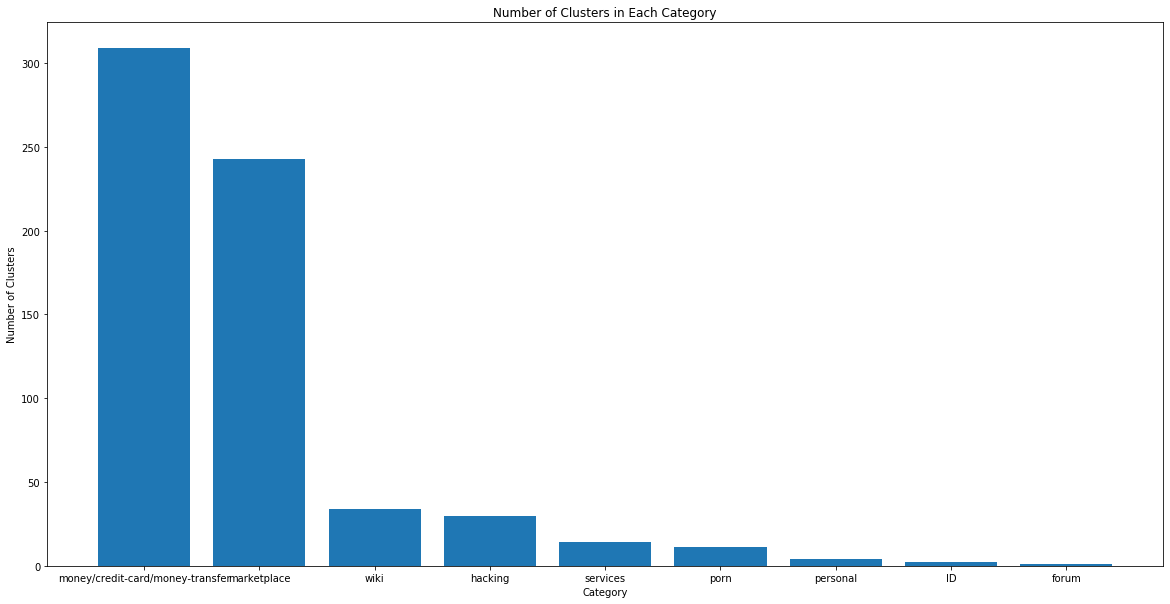

In [20]:
plt.figure(figsize=(20,10))
plt.bar(df_classified_count['category'], df_classified_count['cluster_name'])
plt.xlabel("Category")
plt.ylabel("Number of Clusters")
plt.title("Number of Clusters in Each Category")
plt.show()

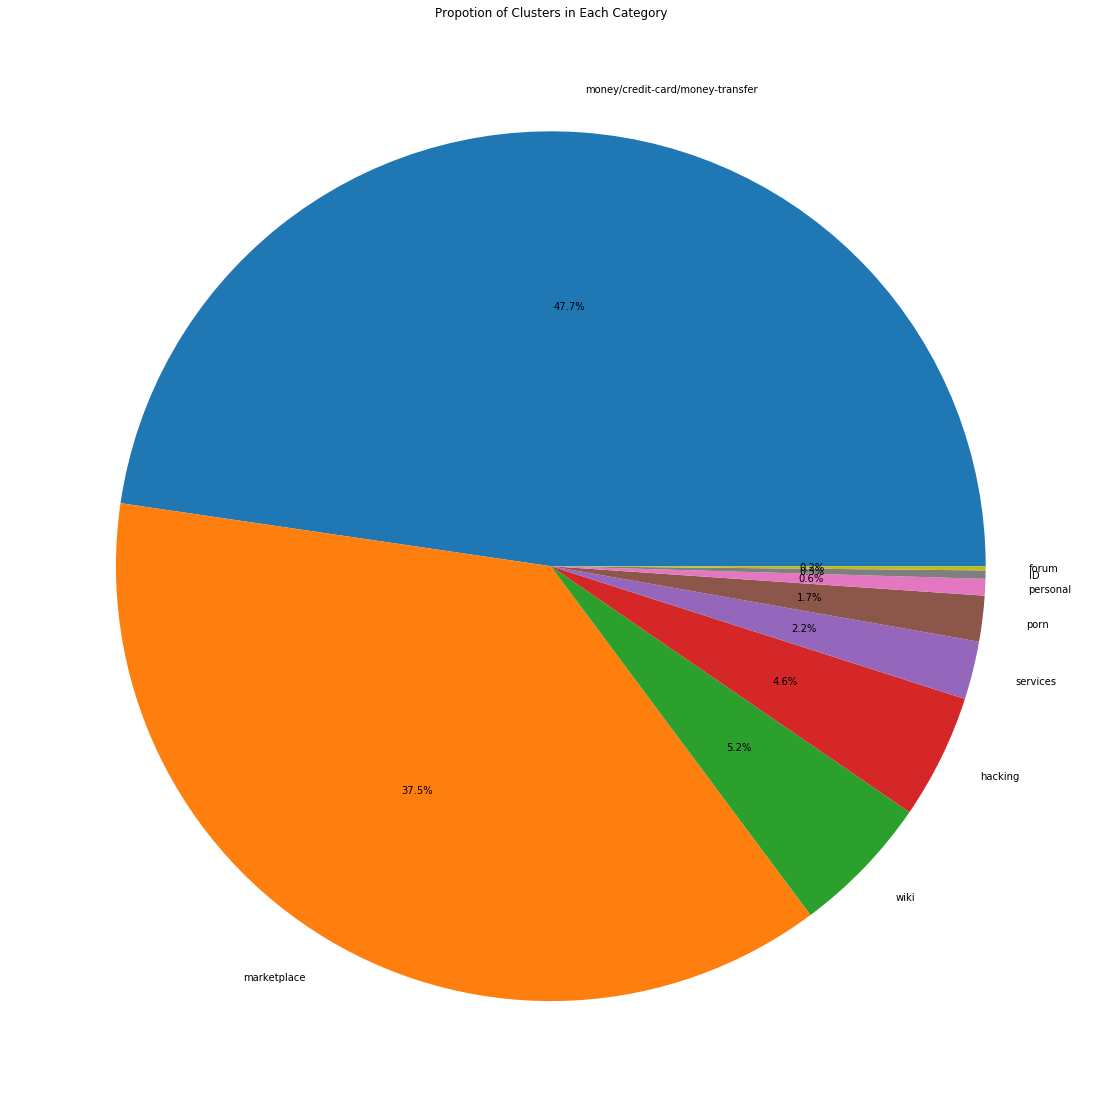

In [21]:
plt.figure(figsize=(20,20))
plt.pie(df_classified_count['cluster_name'], labels=df_classified_count['category'], autopct='%1.1f%%')
plt.title("Propotion of Clusters in Each Category")
plt.show()

In [22]:
# Search with the dictionary of site class words
df_unclassified = df_test_eng_copy.copy()
for site_class in keywords_dict_preprocessed.keys():
    counter = 0
    search_keywords = '|'.join(keywords_dict_preprocessed[site_class])
    filter_index = df_unclassified['title_token'].str.contains(search_keywords, case=False, na=False)
    if filter_index.any:
        df_unclassified = df_unclassified[~filter_index]

# Unclassified clusters
# i.e. None of the keywords in the dictionary is found in the cluster tokens
df_unclassified

,cluster_name,domain,url,title,body_text,body_token,title_token,language
1,$$ The Green Machine $$ - Error,['he22pncoselnm54h'],['he22pncoselnm54h.onion'],[$$ The Green Machine $$ - Error ],[$$ The Green Machine $$ - Error You have been...,"[machin, error, log, session, ha, expir, pleas]",machin error,en
3,&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&#...,['darkfailllnkf4vf'],['darkfailllnkf4vf.onion'],[&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&...,"[d﻿ark.fai﻿l: Which darknet sites are online?,...","[ark, darknet, site, onlin, darknet, site, onl...",darknet site onlin,en
4,&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dres...,['rvy6qmlqfstv6rlz'],['rvy6qmlqfstv6rlz.onion'],[&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dre...,"[<<</>> Chaos Computer Club Dresden | c3d2, <<...","[chao, comput, club, dresden, chao, comput, cl...",lt lt lt gt gt chao comput club dresden,en
5,*** Deep Web Radio ***,['76qugh5bey5gum7l'],"['76qugh5bey5gum7l.onion/status.xsl', '76qugh5...","[*** Deep Web Radio ***, *** Deep Web Radio ***]","[*** Deep Web Radio ***, Compare: 76qugh5bey5g...","[web, radio, compar, bey, gum, onion, web, rad...",web radio web radio,en
7,--- ULTRAMIXER --- | Bitcoin Mixer | Bitcoin T...,['hvnjtt5plknbs5hg'],['hvnjtt5plknbs5hg.onion'],[--- ULTRAMIXER --- | Bitcoin Mixer | Bitcoin ...,[--- ULTRAMIXER --- | Bitcoin Mixer | Bitcoin ...,"[bitcoin, mixer, bitcoin, tumbler, bitcoin, mi...",bitcoin mixer bitcoin tumbler bitcoin mix serv...,en
...,...,...,...,...,...,...,...,...
1295,toogle Dark Web Search Engine Search Tor Hidde...,['dwforumscr4ik7p4'],"['dwforumscr4ik7p4.onion', 'dwforumscr4ik7p4.o...",[toogle Dark Web Search Engine Search Tor Hidd...,[toogle Dark Web Search Engine Search Tor Hidd...,"[toogl, dark, engin, search, tor, web, hideen,...",toogl dark engin search tor web hideen link to...,en
1301,unique_opportunities,['5lsyugnfurxbj7w7omgi53acj5gyqvlirlqxz35qn26c...,['5lsyugnfurxbj7w7omgi53acj5gyqvlirlqxz35qn26c...,"[unique_opportunities, unique_opportunities, u...","[unique_opportunities, unique_opportunities, S...","[clone, credit, card, home, faq, feedback, con...",,en
1304,| TheYOSH.nl,['ctzzqqimlfamyhrc'],['ctzzqqimlfamyhrc.onion'],[| TheYOSH.nl],"[| TheYOSH.nl, Skip to main content, User acco...","[theyosh, nl, skip, content, user, account, me...",theyosh nl,en
1331,约伊兹的萌狼乡手札,"['horoiomuy6xignjv', 'qty3gmiq3zhs7whorla4ynvm...","['horoiomuy6xignjv.onion', 'qty3gmiq3zhs7whorl...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]","[约伊兹的萌狼乡手札, vertical_align_top重新开始？🙃, menu, 约伊...","[约伊兹的萌狼乡手札, menu, 约伊兹的萌狼乡手札, more_vert, ホロ, 且被...",约伊兹的萌狼乡手札 约伊兹的萌狼乡手札,en


In [23]:
# df_classified_joined.to_csv('../data/classfied_keyword_eng_sites.csv')
# df_unclassified.to_csv('../data/unclassfied_keyword_eng_sites.csv')